# Treinamento do modelo de previsão de séries temporais

- Aqui temos o carregamento e a preparação dos dados já refinados extraídos da base pública do SNGPC
- O município de escolha para desenvolvimento do modelo foi o de Belo Horizonte
- Foi utilizado para criação do modelo, modelos de regressão comuns para as séries temporais
- A modelagem foi feita para cada um dos principais SKUs vendidos ao longo de toda a série temporal, portanto temos um modelo para cada SKU
- As variáveis explicativas serão, o mesmo valor de venda daquele SKU nos 5 meses passados, fechando um conjunto de 4 meses (sendo o último o previsto)

In [80]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import joblib

# 01) Importando e transformando os dados

In [2]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
data_refined_path = os.path.join(dataPath, 'refined')
modelsPath = os.path.join(rootPath, 'models')

In [3]:
dados = pd.read_csv(os.path.join(data_refined_path, 'DF_REFINED_EDA_INDUSTRIALIZADOS.csv'), sep=';')

In [4]:
# Visualizando tipo das variáveis e uma prévia do dataframe
dados.info()
dados.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92425 entries, 0 to 92424
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   KEY_SKU_MEDICAMENTO  92425 non-null  object
 1   QTD_VENDIDA          92425 non-null  int64 
 2   DATA                 92425 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


,KEY_SKU_MEDICAMENTO,QTD_VENDIDA,DATA
0,ACEBROFILINA 5 MG/ML XPE CT FR PLAS AMB X 120 ...,1,2017-10-01
1,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,1,2017-10-01
2,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,7,2017-10-01
3,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,38,2017-10-01
4,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,154,2017-10-01


In [5]:
# Persisinto o tipo de dado da coluna data como datetime

dados['DATA'] = pd.to_datetime(dados['DATA'])

In [6]:
# Criando variáveis de tempo para vacilitar as visualizações futuras

dados['MES'] = dados['DATA'].dt.month_name()
dados['ANO'] = dados['DATA'].dt.year

In [7]:
# Verificando tamnho do dataframe

total_obersvacoes = dados.shape[0]
total_medicamentos_vendidos = dados['QTD_VENDIDA'].sum()
min_serie_temporal = dados['DATA'].min()
max_serie_temporal = dados['DATA'].max()

print("Total de observações:", total_obersvacoes)
print("Total de medicamentos vendidos:", total_medicamentos_vendidos)
print(f"Série histórica dos dados de {min_serie_temporal} até {max_serie_temporal}")

Total de observações: 92425
Total de medicamentos vendidos: 34667865
Série histórica dos dados de 2017-10-01 00:00:00 até 2021-10-01 00:00:00


In [8]:
# Conferencia se possuem dados nulos
dados.isnull().sum()

KEY_SKU_MEDICAMENTO    0
QTD_VENDIDA            0
DATA                   0
MES                    0
ANO                    0
dtype: int64

In [9]:
# Visualizando os SKUs que mais tiveram vendas na série temporal completa

df_pareto = dados.groupby('KEY_SKU_MEDICAMENTO').sum('QTD_VENDIDA').sort_values('QTD_VENDIDA', ascending=False)
df_pareto['P%_DO_TOTAL'] = (df_pareto['QTD_VENDIDA'] / total_medicamentos_vendidos) * 100

df_pareto.head(10)

,QTD_VENDIDA,ANO,P%_DO_TOTAL
KEY_SKU_MEDICAMENTO,,,
AMOXICILINA TRI-HIDRATADA + CLAVULANATO DE POTÁSSIO 875 MG + 125 MG COM REV CT FR VD AMB X 20,739590,98945,2.133359
CARBONATO DE LÍTIO 300 MG COM REV CT BL AL PLAS TRANS X 50,646469,98945,1.864750
CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS TRANS X 30,596083,98945,1.719411
HEMIFUMARATO DE QUETIAPINA 25 MG COM REV CT BL AL PLAS OPC X 30,525483,98945,1.515764
HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 20,525208,98945,1.514971
OXALATO DE ESCITALOPRAM 10 MG COM REV CT BL AL PLAS TRANS X 30,495061,98945,1.428011
OXCARBAZEPINA 300 MG COM REV CT BL AL PLAS INC X 30,357875,98945,1.032296
CLONAZEPAM 2 MG COM CT BL AL PLAS TRANS X 30,270840,98945,0.781242
HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 30,245160,98945,0.707168


Será construído 10 diferentes modelos, para os 10 medicamentos listados acima, por serem os principais presentes na série histórica filtrada.

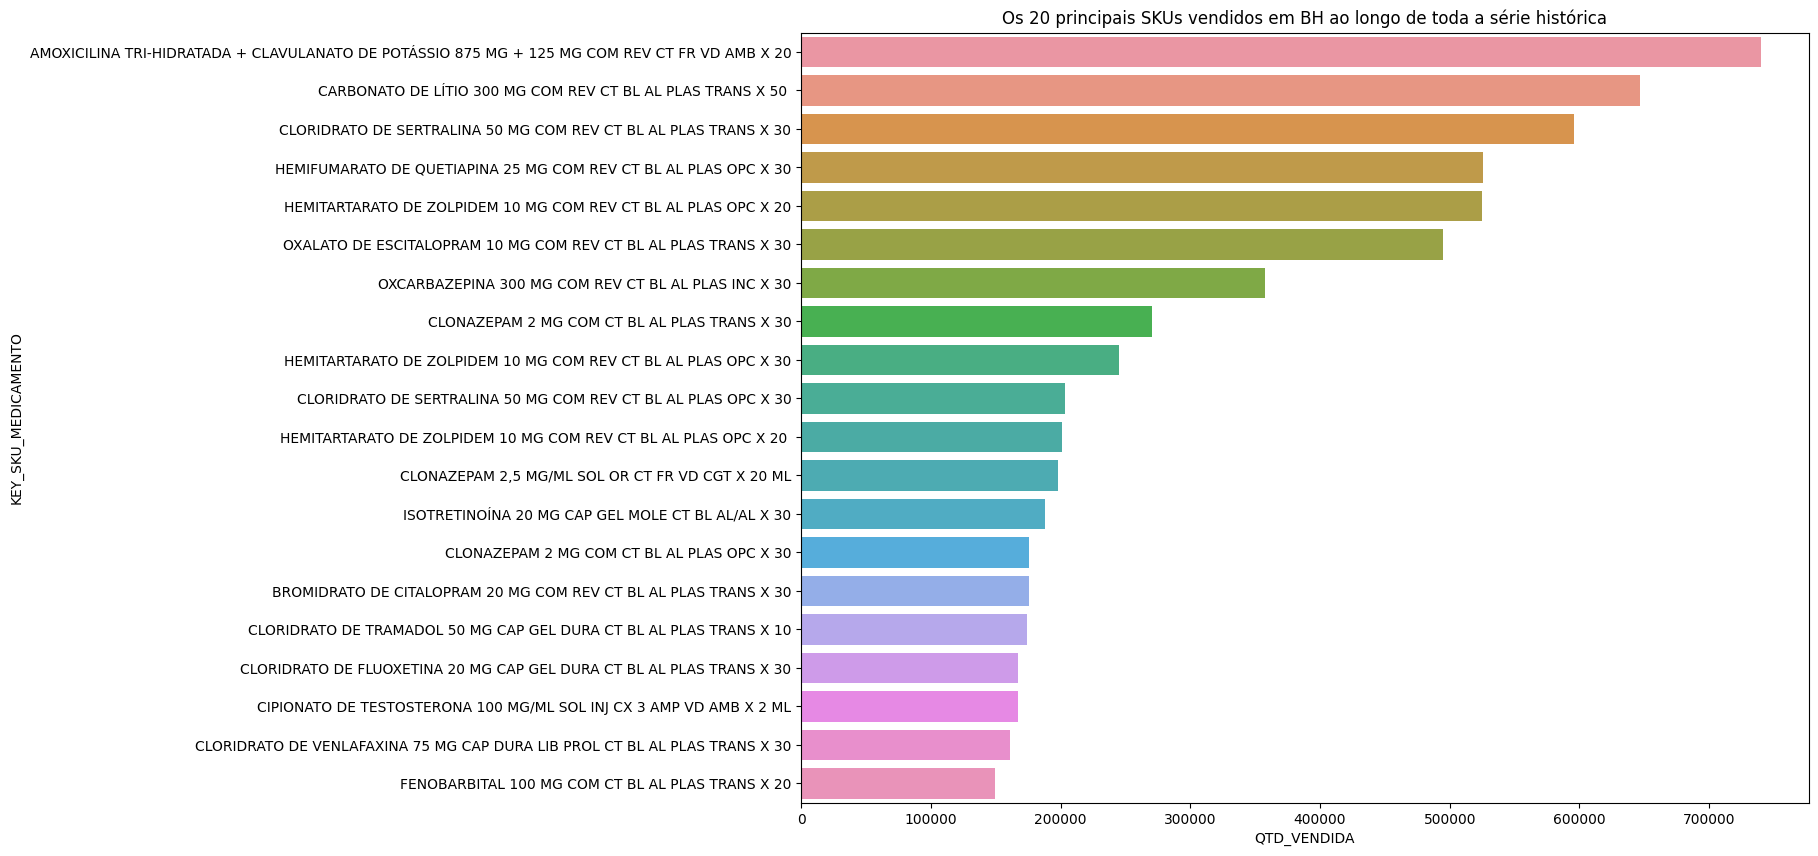

In [10]:
# Visualizando os principais medicamentos vendidos
plt.figure(figsize=(13,10))
sns.barplot(data=df_pareto.head(20).reset_index(), y='KEY_SKU_MEDICAMENTO', x='QTD_VENDIDA')
plt.title("Os 20 principais SKUs vendidos em BH ao longo de toda a série histórica")
plt.show()

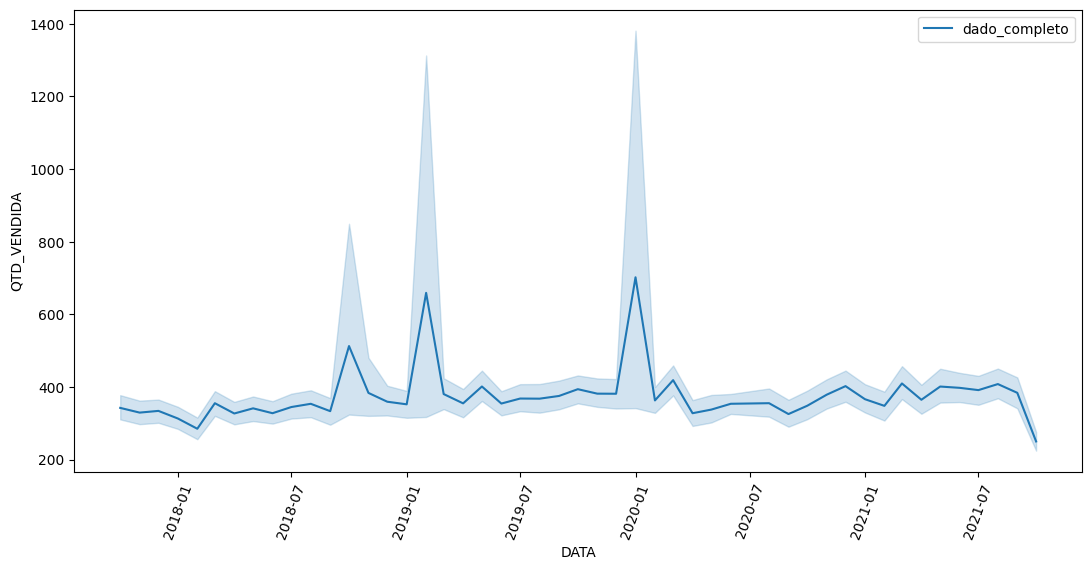

In [11]:
# Visualizando a série histórica

plt.figure(figsize=(13,6))
sns.lineplot(x='DATA',y='QTD_VENDIDA', data=dados, label='dado_completo')
plt.xticks(rotation=70)
plt.show()

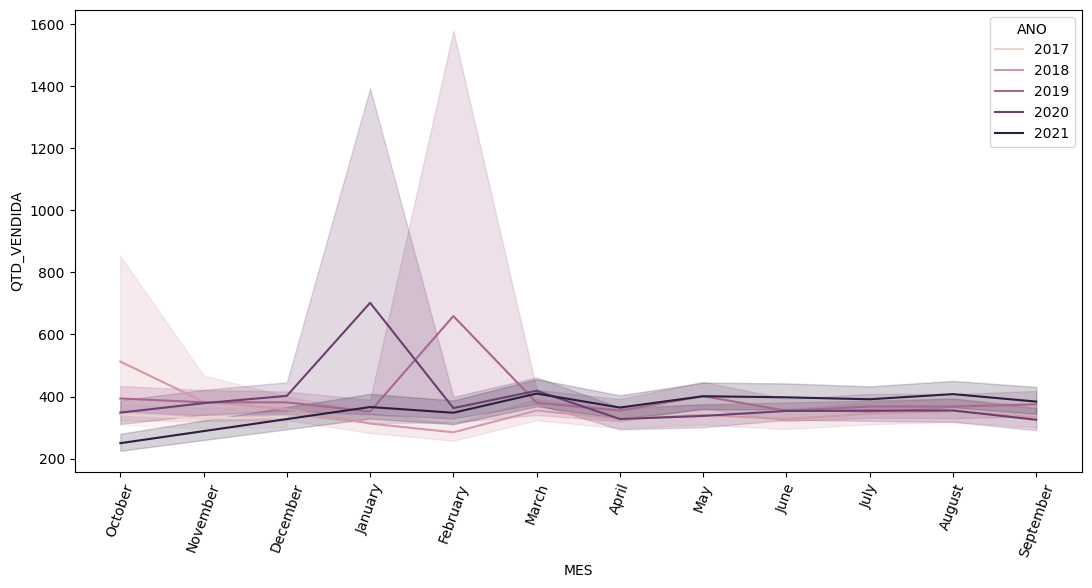

In [12]:
# Visualizando a série histórica

plt.figure(figsize=(13,6))
sns.lineplot(x='MES',y='QTD_VENDIDA', data=dados, hue='ANO')
plt.xticks(rotation=70)
plt.show()

# 02) Construção do conjunto de dados de treino e teste

In [13]:
# Listando os 10 medicamentos mais vendidos

lista_princiapis_skus = list(df_pareto.head(10).reset_index()['KEY_SKU_MEDICAMENTO'])

In [14]:
# Filtrando os dados com a lista anterior
df = dados.query(f"KEY_SKU_MEDICAMENTO == {lista_princiapis_skus}")

In [15]:
# Filtrando as colunas necessárias e ordenando pela série histórica

df = df.drop(columns=['ANO', 'MES'])
df = df.sort_values('DATA')

In [16]:
df.head()

,KEY_SKU_MEDICAMENTO,QTD_VENDIDA,DATA
160,AMOXICILINA TRI-HIDRATADA + CLAVULANATO DE POT...,1714,2017-10-01
454,CARBONATO DE LÍTIO 300 MG COM REV CT BL AL PLA...,635,2017-10-01
635,CLONAZEPAM 2 MG COM CT BL AL PLAS TRANS X 30,5100,2017-10-01
996,CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL A...,2041,2017-10-01
1002,CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL A...,9781,2017-10-01


In [17]:
# Função que filtra qual o SKU e coloca a data como index do df
def filter_sku(SKU):
    df_pipe = df.query(f"KEY_SKU_MEDICAMENTO == '{SKU}'")
    df_pipe = df_pipe.drop(columns=["KEY_SKU_MEDICAMENTO", "DATA"])
    return df_pipe

In [18]:
# Função que forma a matriz que irá formar os dados que são necessário para previsão
# O valor mensal do SKU será previsto com o resultado da sua venda de dois meses anteriores 

def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['QTD_VENDIDA'].shift(-i)
        i = i + 1
    if i == window_length:
        df['y'] = df['QTD_VENDIDA'].shift(-i)
    df = df.dropna(axis=0)
    return df

In [19]:
# Função que separa os dados em treino e teste e faz a normalização do X

def separa_treino_teste(dataframe, tamanho_teste):
    scaler = StandardScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(dataframe), columns= dataframe.columns)

    x = df_norm.drop(columns=['y'])
    y = df_norm['y']
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1337, test_size=tamanho_teste)
    
    return X_train, X_test, y_train, y_test

In [24]:
def pipeline_preparacao_dados(sku):
    df = filter_sku(SKU=sku)
    df_pipe = window_input(5, df)

    X_train, X_test, y_train, y_test = separa_treino_teste(df_pipe, tamanho_teste=0.2)

    return X_train, X_test, y_train, y_test

# 03) Construção do pipeline de treino e teste do modelo

In [38]:
# Criando a função de treinamento e retorna as métricas de validação

def treinaFazPrevisao(modelo, X_train, X_test, y_train, y_test):
    model = modelo
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    return model, r2, rmse

In [39]:
# Função que une o pipeline de separação com o pipeline de treinamento
def pipeline_modelo(indice):
    print('-'*100)

    nome_sku = str(lista_princiapis_skus[indice])
    print(f"Treinamento dos modelos para o SKU: {nome_sku}")
    

    # Separa os dados para treinamento e teste
    X_train, X_test, y_train, y_test = pipeline_preparacao_dados(lista_princiapis_skus[indice])

    # Realiza os treinamento com diversos modelos
    linear, r2_linear, rmse_linear = treinaFazPrevisao(LinearRegression(), X_train, X_test, y_train, y_test)
    dtree, r2_decisiontree, rmse_decisiontree = treinaFazPrevisao(DecisionTreeRegressor(random_state=1337), X_train, X_test, y_train, y_test)
    rforest, r2_randomforest, rmse_randomforest = treinaFazPrevisao(RandomForestRegressor(random_state=1337), X_train, X_test, y_train, y_test)
    gb, r2_gradient, rmse_gradient = treinaFazPrevisao(GradientBoostingRegressor(random_state=1337), X_train, X_test, y_train, y_test)
    rna, r2_rna, rmse_rna = treinaFazPrevisao(MLPRegressor(random_state=1337), X_train, X_test, y_train, y_test)

    lista_modelos = [linear, dtree, rforest, gb, rna]

    dados_resultados = {
        'modelo': ['Linear Regression', 'Decission Tree', 'Random Forest', 'Gradient Boosting', 'RNA'],
        'r2': [r2_linear, r2_decisiontree, r2_randomforest, r2_gradient, r2_rna],
        'rmse': [rmse_linear, rmse_decisiontree, rmse_randomforest, rmse_gradient, rmse_rna]
    }

    print("Resultados dos modelos treinados\n")
    print(pd.DataFrame(dados_resultados))

    print('-'*100)
    
    return lista_modelos

# 04) Executa o treinamento para os top 10 SKUs

In [41]:
lista_modelos_0 = pipeline_modelo(0)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: AMOXICILINA TRI-HIDRATADA + CLAVULANATO DE POTÁSSIO 875 MG + 125 MG COM REV CT FR VD AMB X 20
Resultados dos modelos treinados

              modelo            r2      rmse
0  Linear Regression   -357.470749  0.219470
1     Decission Tree -37124.775093  2.233499
2      Random Forest  -3341.012347  0.670119
3  Gradient Boosting  -4075.258351  0.740080
4                RNA   -336.105536  0.212829
----------------------------------------------------------------------------------------------------


In [42]:
lista_modelos_1 = pipeline_modelo(1)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CARBONATO DE LÍTIO 300 MG COM REV CT BL AL PLAS TRANS X 50 
Resultados dos modelos treinados

              modelo            r2       rmse
0  Linear Regression -1.679705e+08  55.836576
1     Decission Tree -1.082493e+01   0.014815
2      Random Forest -2.389686e+04   0.666011
3  Gradient Boosting -1.471685e+05   1.652765
4                RNA -1.315798e+04   0.494212
----------------------------------------------------------------------------------------------------


In [43]:
lista_modelos_2 = pipeline_modelo(2)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS TRANS X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression -0.384005  0.982645
1     Decission Tree -0.763414  1.109188
2      Random Forest  0.035045  0.820505
3  Gradient Boosting -0.657817  1.075465
4                RNA -0.061941  0.860752
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
lista_modelos_3 = pipeline_modelo(3)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: HEMIFUMARATO DE QUETIAPINA 25 MG COM REV CT BL AL PLAS OPC X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression  0.647801  0.687589
1     Decission Tree  0.610057  0.723496
2      Random Forest  0.708777  0.625242
3  Gradient Boosting  0.674391  0.661124
4                RNA  0.644958  0.690359
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
lista_modelos_4 = pipeline_modelo(4)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 20
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression  0.688371  0.563467
1     Decission Tree  0.365056  0.804298
2      Random Forest  0.698578  0.554162
3  Gradient Boosting  0.621317  0.621137
4                RNA  0.734754  0.519845
----------------------------------------------------------------------------------------------------


In [46]:
lista_modelos_5 = pipeline_modelo(5)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: OXALATO DE ESCITALOPRAM 10 MG COM REV CT BL AL PLAS TRANS X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression  0.288595  0.772005
1     Decission Tree -2.129942  1.619310
2      Random Forest  0.315422  0.757309
3  Gradient Boosting  0.239600  0.798147
4                RNA  0.093293  0.871556
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
lista_modelos_6 = pipeline_modelo(6)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: OXCARBAZEPINA 300 MG COM REV CT BL AL PLAS INC X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression -0.270101  2.376062
1     Decission Tree -0.125981  2.237197
2      Random Forest -0.124962  2.236184
3  Gradient Boosting -0.125590  2.236809
4                RNA -0.134711  2.245853
----------------------------------------------------------------------------------------------------


In [48]:
lista_modelos_7 = pipeline_modelo(7)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CLONAZEPAM 2 MG COM CT BL AL PLAS TRANS X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression  0.324780  0.619548
1     Decission Tree  0.056165  0.732488
2      Random Forest  0.039683  0.738856
3  Gradient Boosting  0.097190  0.716392
4                RNA -0.568403  0.944238
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
lista_modelos_8 = pipeline_modelo(8)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression  0.905038  0.350258
1     Decission Tree  0.932756  0.294740
2      Random Forest  0.960947  0.224616
3  Gradient Boosting  0.957415  0.234552
4                RNA  0.949512  0.255392
----------------------------------------------------------------------------------------------------


In [50]:
lista_modelos_9 = pipeline_modelo(9)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS OPC X 30
Resultados dos modelos treinados

              modelo        r2      rmse
0  Linear Regression  0.905286  0.292994
1     Decission Tree  0.757485  0.468837
2      Random Forest  0.855169  0.362312
3  Gradient Boosting  0.857341  0.359585
4                RNA  0.938697  0.235718
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Conclusões

Com a quantidade de dados utilizadas da série histórica, para alguns SKUs não foi possível realizar boas regresões. Entretanto, para dois SKUs foi possível encontrar bons modelos preditivos.

 Uma extensão da série histórica pode ser suficiente para realizar melhores previsões

**SKUs que tem regressões ok:**

- HEMIFUMARATO DE QUETIAPINA 25 MG COM REV CT BL AL PLAS OPC X 30: Random Forest com 70% e 0.6252 de rmse
- HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 20: RNA com 73% de r2 e 0.5198 de rmse

**SKUs que tem regressões excelentes:**

- HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 30: Random Forest com 96% e 0.2246 de rmse
- CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS OPC X 30: RNA com 93% de r2 e 0.2357 de rmse

# 05) Avaliando os melhores modelos treinados 

Isolando os dois modelos que tiveram resultados intressantes e visualizando a curva de predição e a distribuição dos resíduos

In [74]:
def curva_regressao_residuos(modelo, indice):

    X_train, X_test, y_train, y_test = pipeline_preparacao_dados(lista_princiapis_skus[indice])
    y = pd.concat([y_train, y_test])
    x = pd.concat([X_train, X_test])
    x['y_previsto'] = modelo.predict(x)
    x['residuos'] = y - x['y_previsto']

    plt.figure(figsize=(8,6))
    sns.regplot(x=x['y_previsto'], y=y, scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.title("Curva de regressão estimada")
    plt.xlabel("Valores previstos")
    plt.ylabel("Valores reais")
    plt.show()

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=x['y_previsto'], y=x['residuos'])
    plt.title("Dispersão dos resíduos")
    plt.xlabel("Valores previstos")
    plt.ylabel("Residuos")
    plt.show()

Para as regressões intermediárias

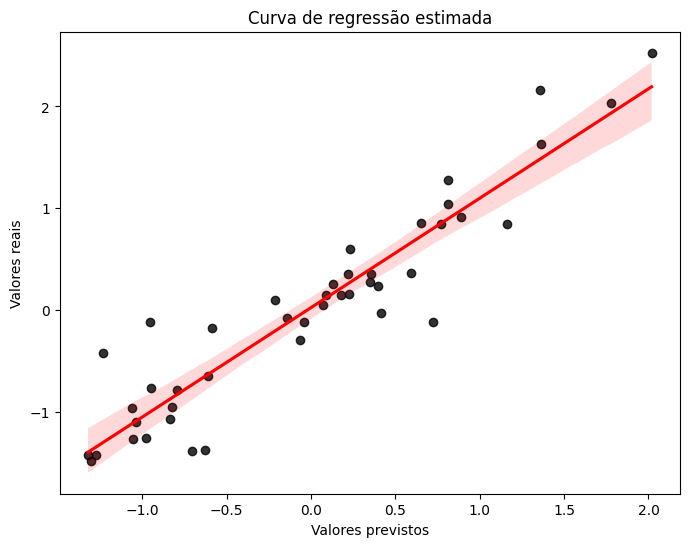

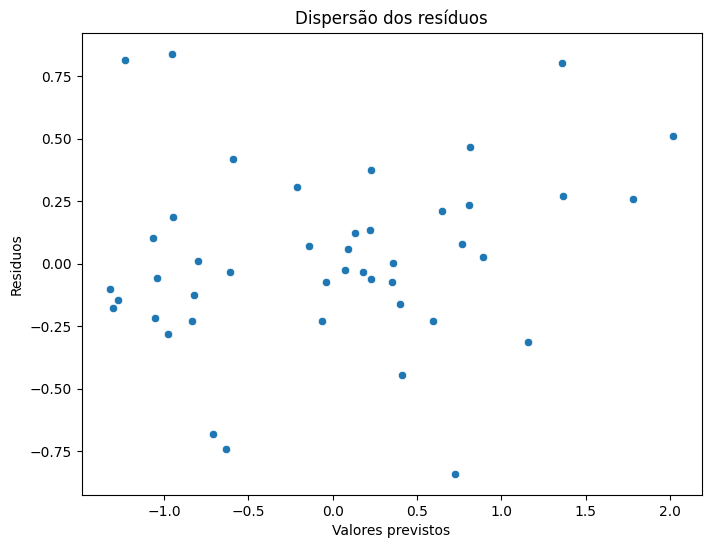

In [77]:
curva_regressao_residuos(lista_modelos_3[2], 3)

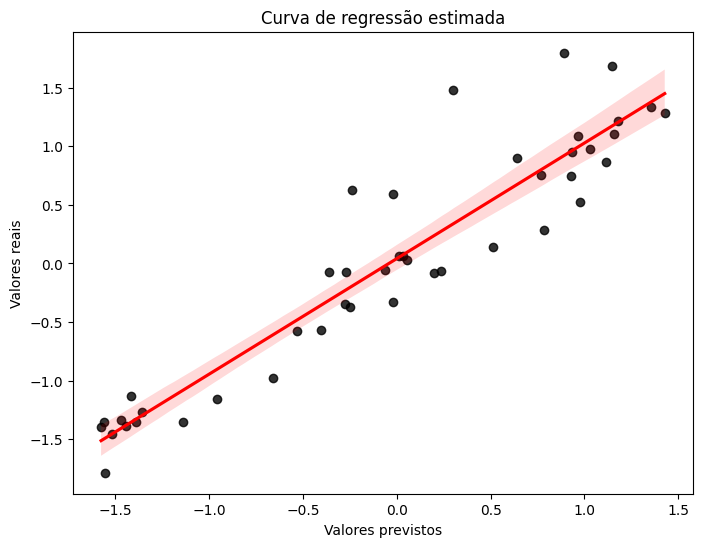

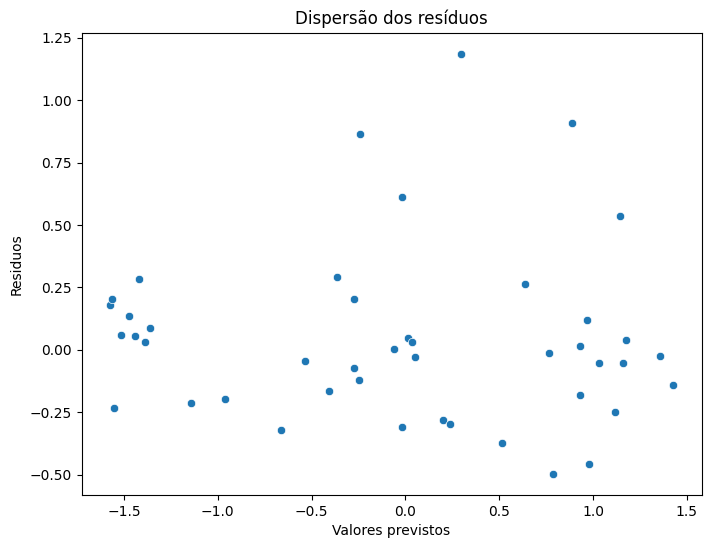

In [78]:
curva_regressao_residuos(lista_modelos_4[4], 4)

Para as melhores regressões

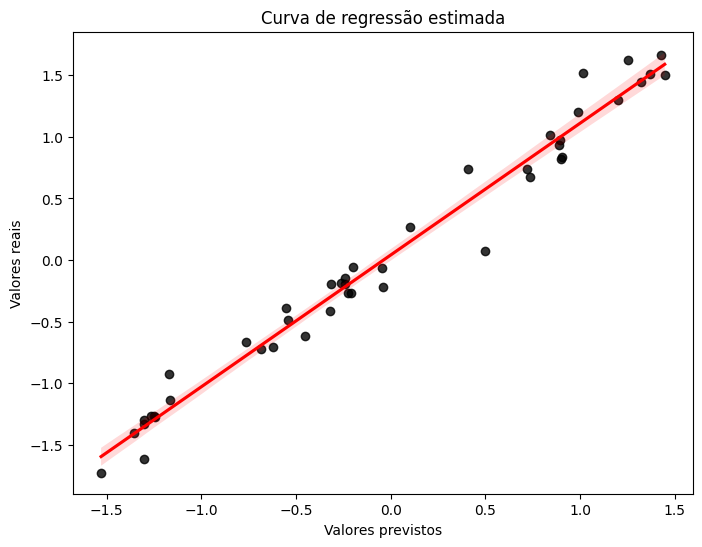

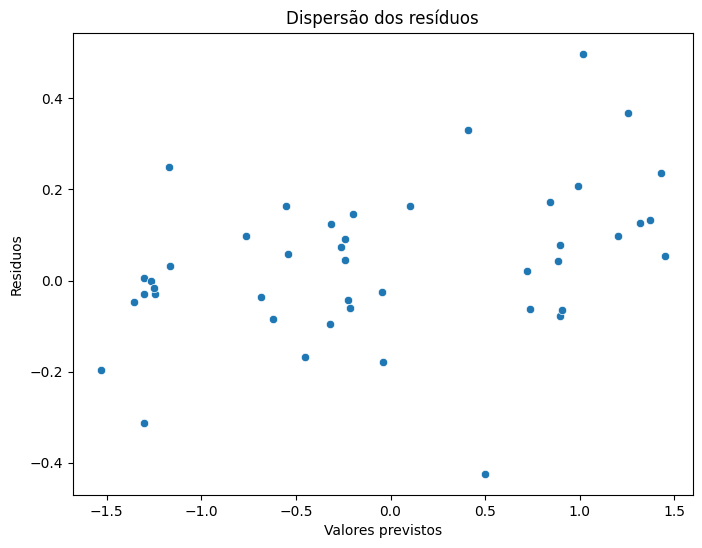

In [75]:
curva_regressao_residuos(lista_modelos_8[2], 8)

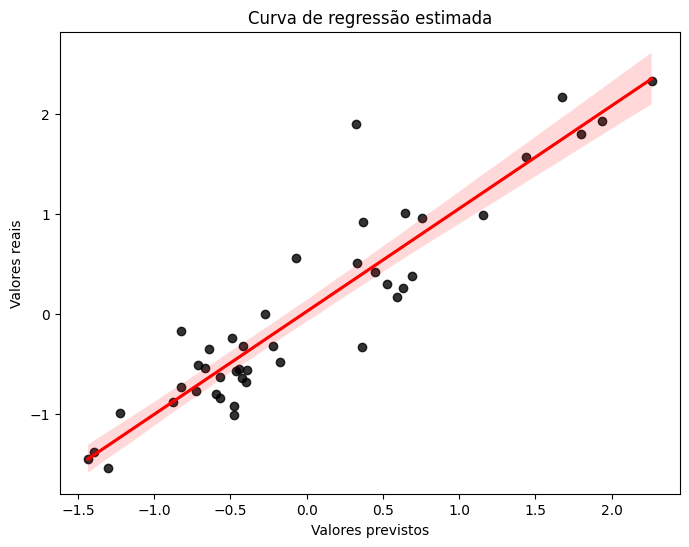

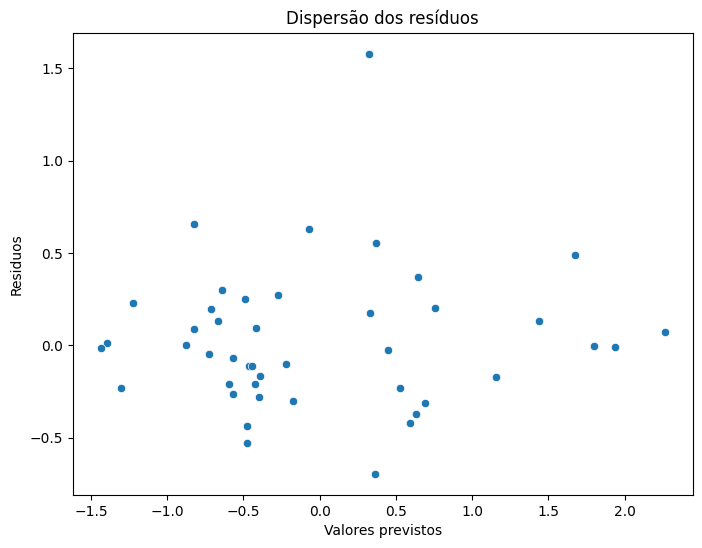

In [76]:
curva_regressao_residuos(lista_modelos_9[4], 9)

# 06) Conclusões

- Foi possível modelar regressões para 4 dos top10 SKUs de Belo Horizonte
- Um aumento na série histórica pode trazer uma melhoria para outros SKUs
- Redes neurais e Random Forests demonstram ser as melhores abordagens

In [87]:
# Salvando os 4 modelos 

dicionario_best_models = {
    'modelo_quetiapina_25mg_30cp': lista_modelos_3[2],
    'modelo_zolpidem_10mg_10cp': lista_modelos_4[4],
    'modelo_zolpidem_10mg_30cp': lista_modelos_8[2],
    'modelo_sertralina_50mg_30cp': lista_modelos_9[4]
}

biblioteca_modelos = os.path.join(modelsPath, 'previsao_demanda_sku.joblib')
dump = joblib.dump(dicionario_best_models, biblioteca_modelos)